In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import plot_loss_curves, pred_and_plot
import os
from pathlib import Path
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


2024-02-29 02:31:56.015795: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 02:31:56.039850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 02:31:56.039872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 02:31:56.039887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 02:31:56.044455: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("./data/pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 2 images in './data/pizza_steak'.
There are 2 directories and 0 images in './data/pizza_steak/test'.
There are 0 directories and 250 images in './data/pizza_steak/test/pizza'.
There are 0 directories and 250 images in './data/pizza_steak/test/steak'.
There are 2 directories and 0 images in './data/pizza_steak/train'.
There are 0 directories and 750 images in './data/pizza_steak/train/pizza'.
There are 0 directories and 750 images in './data/pizza_steak/train/steak'.


In [3]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = Path("./data/pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


Image shape: (512, 512, 3)


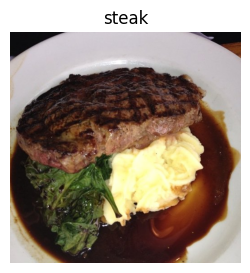

In [4]:
# def for view random imagen
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.figure(figsize=(3,3))
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# View a random image from the training dataset
img = view_random_image(target_dir="./data/pizza_steak/train/", target_class="steak")

In [5]:
# View the image shape
img.shape # returns (width, height, colour channels)

(512, 512, 3)

In [6]:
# preproced data
tf.random.set_seed(42)

# Create ImageDataGenerator training instance with data augmentation

train_datagen_augmented = ImageDataGenerator( 
    rescale=1./255, # tranform data to values between 0 & 1
    rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int)
    shear_range=0.2, # shear the image
    zoom_range=0.2, # zoom into the image
    width_shift_range=0.2, # shift the image width ways
    height_shift_range=0.2, # shift the image height ways
    horizontal_flip=True ) # flip the image on the horizontal axis

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup path the data directories
train_dir = "./data/pizza_steak/train/"
test_dir = "./data/pizza_steak/test/"

# Import data from directories and

train_data_augmented = train_datagen_augmented.flow_from_directory( train_dir,
                                                                    target_size=(224, 224),
                                                                    batch_size=32,
                                                                    class_mode='binary',
                                                                    shuffle=True, seed=42)

train_data = train_datagen.flow_from_directory( train_dir, target_size=(224, 224), # size image que queremos
                                               batch_size=32, class_mode='binary', shuffle=True, seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode="binary", seed=42)

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [7]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

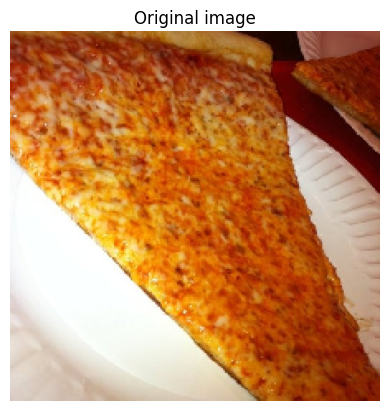

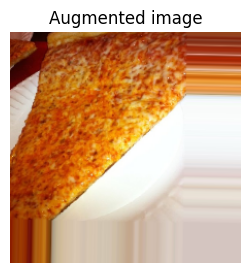

In [8]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure(figsize=(3,3))
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [9]:
# Build a CNN model tinyVGG
model_1 = keras.Sequential([
    keras.layers.Conv2D( filters=10, kernel_size=3, # can also be (3, 3)
            activation="relu", input_shape=(224,224,3), # Height, Weight, Channel_Color
            strides=1, padding='valid'), # "valid" or "same" es igual
    keras.layers.Conv2D(10,3,activation="relu"), # Esto es lo mismo que arriba
    keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    keras.layers.Conv2D(10, 3, activation="relu"),
    keras.layers.Conv2D(10, 3, activation="relu"),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid") ])



model_1.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

history = model_1.fit(x=train_data_augmented, epochs=5, steps_per_epoch=len(train_data_augmented), # 1500/32 = 47 images load
                      validation_data=valid_data, validation_steps=len(valid_data))


2024-02-29 02:31:58.056655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 02:31:58.059979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 02:31:58.060079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/5


2024-02-29 02:32:00.204036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-29 02:32:01.380896: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f53f000d2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 02:32:01.380915: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-29 02:32:01.386255: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 02:32:01.454090: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 15s 219ms/step - loss: 0.7433 - accuracy: 0.5067 - val_loss: 0.6648 - val_accuracy: 0.5440
Epoch 2/5
47/47 [==============================] - 9s 191ms/step - loss: 0.6412 - accuracy: 0.6420 - val_loss: 0.5110 - val_accuracy: 0.7860
Epoch 3/5
47/47 [==============================] - 9s 190ms/step - loss: 0.5535 - accuracy: 0.7260 - val_loss: 0.4937 - val_accuracy: 0.8180
Epoch 4/5
47/47 [==============================] - 9s 189ms/step - loss: 0.5046 - accuracy: 0.7640 - val_loss: 0.3861 - val_accuracy: 0.8420
Epoch 5/5
47/47 [==============================] - 9s 189ms/step - loss: 0.4928 - accuracy: 0.7687 - val_loss: 0.4083 - val_accuracy: 0.8620


In [10]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

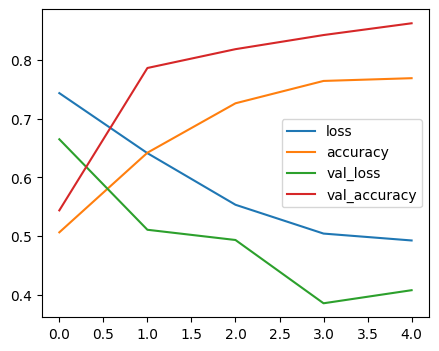

In [11]:
pd.DataFrame(history.history).plot(figsize=(5, 4));

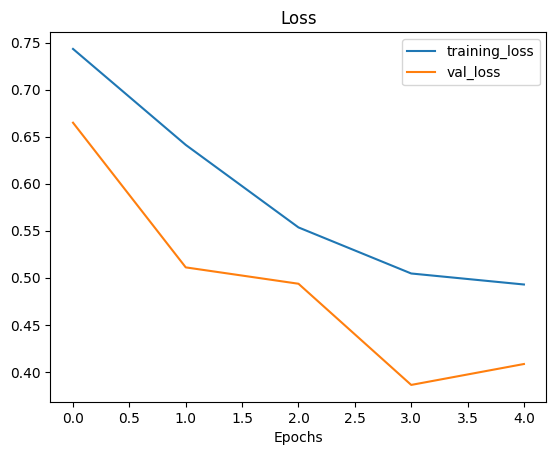

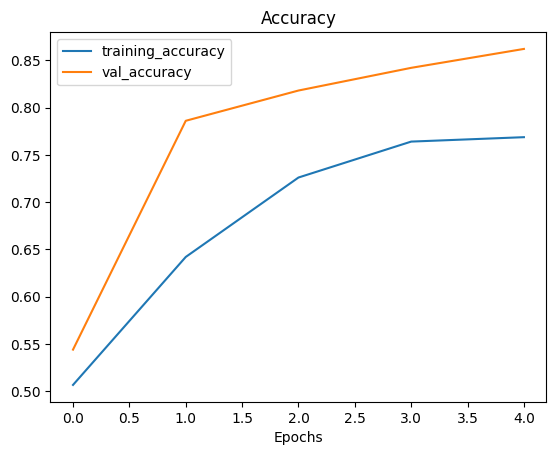

In [12]:
# Check out the loss curves of model
plot_loss_curves(history)

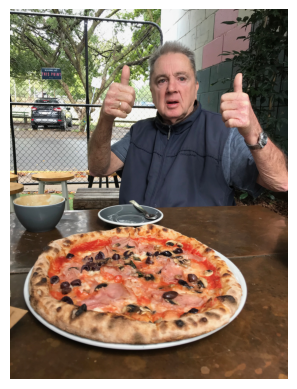

In [14]:
# View our example image
imagen_steak_dir = "./data/pizza_steak/03-steak.jpeg"
imagen_pizza_dir = "./data/pizza_steak/04-pizza-dad.jpeg"

plt.imshow( mpimg.imread(imagen_pizza_dir))
plt.axis(False);

In [15]:
# Check the shape of our image
mpimg.imread(imagen_pizza_dir).shape

(4032, 3024, 3)

In [16]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):

  img = tf.io.read_file(filename)
  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])  
  img = img/255. # Rescale the image (between 0 & 1)
  
  print(f"Shape before new dimension: {img.shape}")
  img = tf.expand_dims(img, axis=0) # add an extra dimension at axis 0
  print(f"Shape after new dimension: {img.shape}")

  return img

imagen_1 = load_and_prep_image(filename=imagen_pizza_dir)
imagen_2 = load_and_prep_image(filename=imagen_steak_dir)

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)
Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


In [17]:
# two class, if value is 0.5> entonces es 1 = steak
pred_1 = model_1.predict(imagen_1)
pred_2 = model_1.predict(imagen_2)

print(f"Value prob of example 1 is: {pred_1}")
print(f"Value prob of example 2 is: {pred_2}")

1/1 [==============================] - 0s 13ms/step
Value prob of example 1 is: [[0.30827588]]
Value prob of example 2 is: [[0.76137406]]


In [18]:
# We can index the predicted class by rounding the prediction probability
pred_class_1 = class_names[int(tf.round(pred_1)[0][0])]
pred_class_2 = class_names[int(tf.round(pred_2)[0][0])]

print(f"Pred example 1, the class is: {pred_class_1}")
print(f"Pred example 2, the class is: {pred_class_2}")

Pred example 1, the class is: pizza
Pred example 2, the class is: steak


## Multi-class Classification

In [38]:
data_dir = "./data/data_multiclass_pizza_steak_other/"

for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in './data/data_multiclass_pizza_steak_other/'.
There are 10 directories and 0 images in './data/data_multiclass_pizza_steak_other/test'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/chicken_curry'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/chicken_wings'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/fried_rice'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/grilled_salmon'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/hamburger'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/ice_cream'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/pizza'.
There are 0 directories and 250 images in './data/data_multiclass_pizza_steak_other/test/ramen'.
There are 0

In [40]:
# dir of train and test data
train_dir = "./data/data_multiclass_pizza_steak_other/train/"
test_dir = "./data/data_multiclass_pizza_steak_other/test/"

In [41]:
# Get the class names for our multi-class dataset
data_dir = Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [42]:
# def for view random imagen
def view_random_image(target_dir, target_class):
  
  target_folder = target_dir + target_class[0] # target_class[0] change of list to str
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  
  plt.figure(figsize=(3,3))
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img

Image shape: (512, 512, 3)


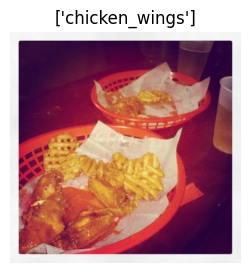

In [49]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choices(class_names)) # get a random class name

In [50]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [51]:
# build model
# model_1 = tf.keras.models.clone_model(model_10)
model_2 = keras.Sequential([
    keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(10, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense( len(class_names), activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_2 = model_2.fit(train_data_augmented, epochs=5, steps_per_epoch=len(train_data_augmented),
                         validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 45s 187ms/step - loss: 2.2475 - accuracy: 0.1789 - val_loss: 2.0175 - val_accuracy: 0.2712
Epoch 2/5
235/235 [==============================] - 44s 188ms/step - loss: 2.0666 - accuracy: 0.2699 - val_loss: 1.9501 - val_accuracy: 0.3208
Epoch 3/5
235/235 [==============================] - 44s 188ms/step - loss: 2.0293 - accuracy: 0.2889 - val_loss: 1.9570 - val_accuracy: 0.3244
Epoch 4/5
235/235 [==============================] - 44s 187ms/step - loss: 1.9875 - accuracy: 0.3157 - val_loss: 1.8714 - val_accuracy: 0.3592
Epoch 5/5
235/235 [==============================] - 44s 187ms/step - loss: 1.9869 - accuracy: 0.3121 - val_loss: 1.8248 - val_accuracy: 0.3796


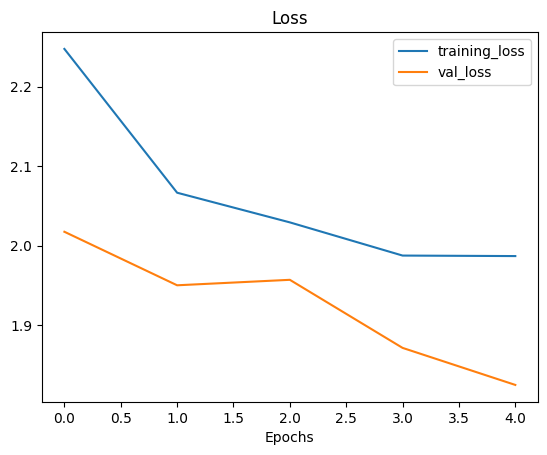

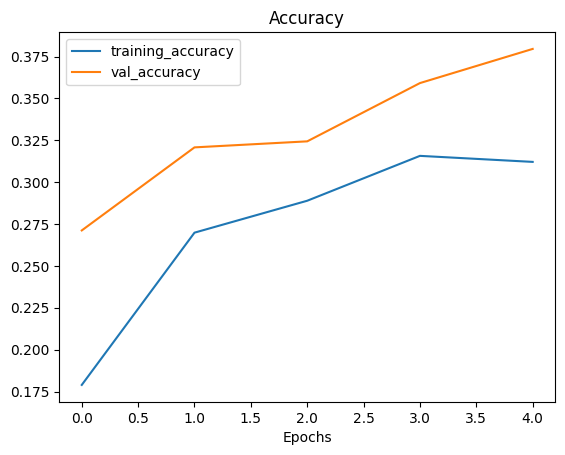

In [52]:
plot_loss_curves(history_2)

1/1 [==============================] - 0s 39ms/step


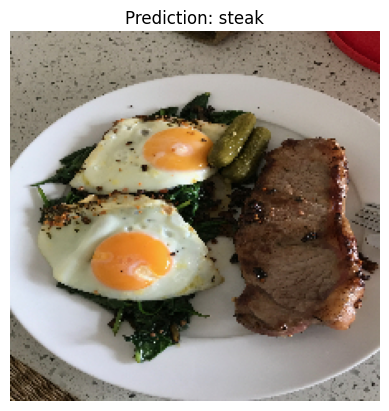

In [53]:
imagen_steak = "./data/pizza_steak/03-steak.jpeg"
imagen_pizza = "./data/pizza_steak/04-pizza-dad.jpeg"
pred_and_plot(model_2, imagen_steak, class_names)

1/1 [==============================] - 0s 12ms/step


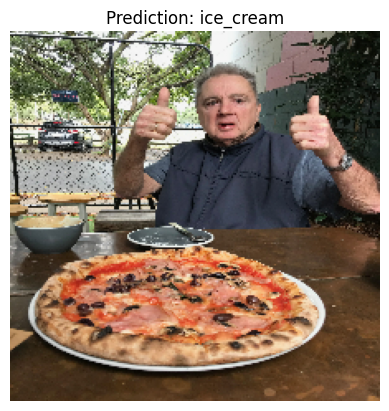

In [54]:
pred_and_plot(model_2, imagen_pizza, class_names)

In [56]:
# Save a model
model_2.save("./save_model/cnn_3")

INFO:tensorflow:Assets written to: ./save_model/cnn_3/assets


INFO:tensorflow:Assets written to: ./save_model/cnn_3/assets


In [57]:
# Load in a model and evaluate it
loaded_model_2 = tf.keras.models.load_model("./save_model/cnn_3/")
loaded_model_2.evaluate(test_data)

79/79 [==============================] - 3s 38ms/step - loss: 1.8248 - accuracy: 0.3796


[1.8247997760772705, 0.37959998846054077]